In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

C:\Users\samuel.sisto\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv('C:\\Users\samuel.sisto\Kaggle\StoreItemDemandForecasting\Data\\train.csv', parse_dates=['date'], index_col=['date'])
test = pd.read_csv('C:\\Users\samuel.sisto\Kaggle\StoreItemDemandForecasting\Data\\test.csv', parse_dates=['date'], index_col=['date'])

In [30]:
len(train)
date_sales = train.drop(['store','item'], axis=1).copy()
len(date_sales)

913000

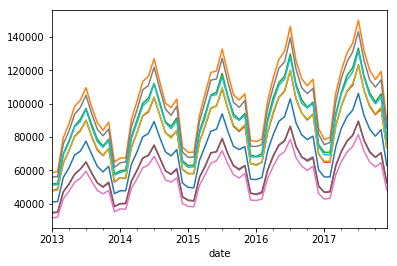

In [56]:
# Number of distinct stores? 10 unique stores
train.store.unique()

# Number of distinct items? 50 unique items
train.item.unique()

# Total number of sales per item, broken down by store
uniq_stores = train.store.unique()
uniq_stores

for x in uniq_stores:
    train[train.store==x].sales.resample('M').sum().plot()

# Total number of sales per store

In [3]:
def test_stationarity(timeseries):

    #Determing rolling statistics   
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

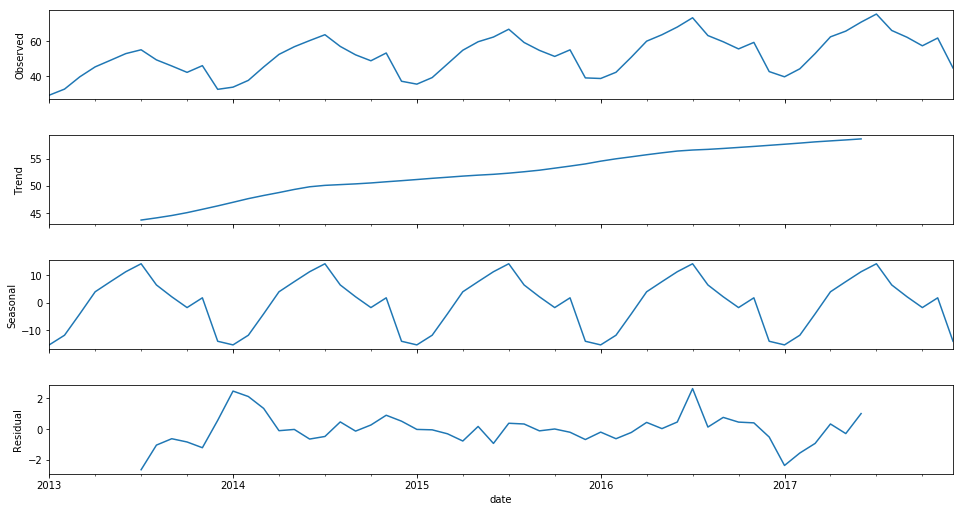

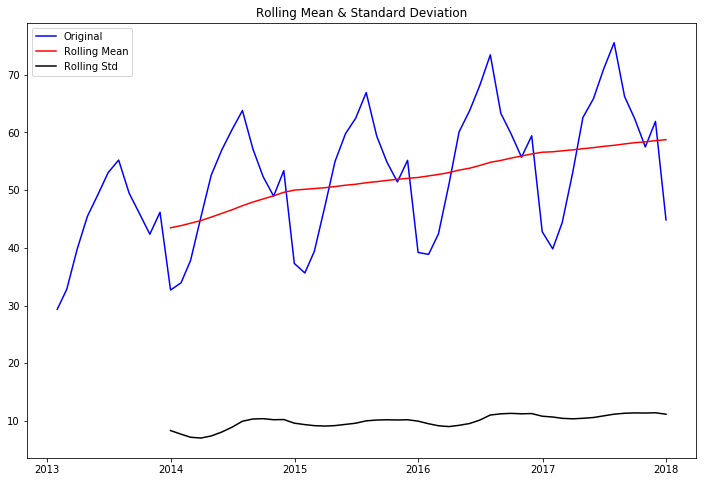

Results of Dickey-Fuller Test:
Test Statistic                 -5.382140
p-value                         0.000004
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [4]:
# Actual modeling: Moving average, exponential smoothing

train['first_difference'] = train.sales - train.sales.shift(1)
#series = train[(train.store==1) & (train.item==1)].first_difference.dropna(inplace=False)
#series = train[(train.store==1) & (train.item==1)].sales.resample('M').sum()
series = train.sales.resample('M').mean()

decomposition = seasonal_decompose(series, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

test_stationarity(series)

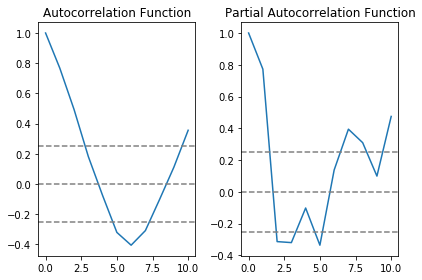

In [5]:
lag_acf = acf(series, nlags=10)
lag_pacf = pacf(series, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

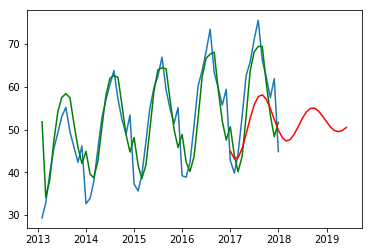

In [63]:
model = ARIMA(series, order=(2, 0, 2))
series = series.astype('float32')
results_ARIMA = model.fit(disp=-1)  

future_fcst = results_ARIMA.forecast(steps=30, exog=None, alpha=0.05)[0]
dates = pd.date_range(start='2017-01-01', end='2019-06-01', freq='MS')
df = pd.DataFrame({'date': dates, 'forecast': future_fcst})
df2 = df.set_index('date')
forecast = df2.forecast

plt.plot(series)
plt.plot(results_ARIMA.fittedvalues, color='green')
plt.plot(forecast, color='red')

#A model with no orders of differencing assumes that the original series is stationary (mean-reverting).
#This makes sense given the results of our Dickey - Fuller test indicating that the population is stationary.

In [ ]:
#Code to create a submission file?
#https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q